In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import loguniform, uniform, randint

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from my_knn import knn_1
from personal_knn import KNNClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from custom_metrics import my_metrics

In [97]:
def params_log_regression(type_regularization, method_parametrs_search, X_train, X_test, y_train, y_test):
    print(type_regularization)
    if method_parametrs_search == 'grid_search':
        if type_regularization == 'none':
            model = LogisticRegression(random_state=42, penalty=None, max_iter=5000)
            params = {
                'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'newton-cholesky']
            }
        elif type_regularization == 'l1':
            model = LogisticRegression(random_state=42, penalty='l1', max_iter=5000)
            params = {
                'C': [0.001, 0.01, 0.1, 1, 10],
                'solver': ['liblinear', 'saga']

            }
        elif type_regularization == 'l2':
            model = LogisticRegression(random_state=42, penalty='l2', max_iter=5000)
            params = {
                'C': [0.001, 0.01, 0.1, 1, 10],
                'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga', 'newton-cholesky']
            }
        else:
            model = LogisticRegression(solver='saga', random_state=42, penalty='elasticnet', max_iter=5000) 
            params = {
                'C': [0.001, 0.01, 0.1, 1, 10],
                'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1]
            }
        return model, params
    elif method_parametrs_search == 'random_search':
        if type_regularization == 'none':
            model = LogisticRegression(random_state=42, penalty=None, max_iter=5000)
            params = {
                'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'newton-cholesky']
            }
        elif type_regularization == 'l1':
            model = LogisticRegression(random_state=42, penalty='l1', max_iter=5000)
            params = {
                'C': loguniform(1e-3, 10),
                'solver': ['liblinear', 'saga']
            }
        elif type_regularization == 'l2':
            model = LogisticRegression(random_state=42, penalty='l2', max_iter=5000)
            params = {
                'C': loguniform(1e-3, 10),
                'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga', 'newton-cholesky']
            }
        else:
            model = LogisticRegression(solver='saga', random_state=42, penalty='elasticnet', max_iter=5000) 
            params = {
                'C': loguniform(1e-3, 10),
                'l1_ratio': uniform(0, 1)
            }
        return model, params
    else:
        def objective(trial):
            if type_regularization == 'none':
                solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag', 'saga', 'newton-cholesky'])
                model = LogisticRegression(solver=solver, random_state=42, penalty=None, max_iter=5000)
            elif type_regularization == 'l1':
                C = trial.suggest_float('C', 1e-3, 10, log=True)
                solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
                model = LogisticRegression(solver=solver, C=C, random_state=42, penalty='l1', max_iter=5000)
            elif type_regularization == 'l2':
                C = trial.suggest_float('C', 1e-3, 10, log=True)
                solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga', 'newton-cholesky'])
                model = LogisticRegression(solver=solver, C=C, random_state=42, penalty='l2', max_iter=5000)
            else:
                C = trial.suggest_float('C', 1e-3, 10, log=True)
                l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
                model = LogisticRegression(solver='saga', C=C, l1_ratio=l1_ratio, random_state=42, penalty='elasticnet', max_iter=5000) 
            model.fit(X_train, y_train)

            y_smt_pred = model.predict(X_test)

            f1 = f1_score(y_test, y_smt_pred)
            return f1  

        study = optuna.create_study(
            direction='maximize'
        )

        study.optimize(objective, n_trials=100)

        print(study.best_params)

        best_params = study.best_params

        if type_regularization == 'l1':
            best_model = LogisticRegression(solver=best_params['solver'], C=best_params['C'], random_state=42, penalty='l1', max_iter=5000)
            
            best_model.fit(X_train, y_train)

            return best_model

        print()

In [98]:
def params_knn_withoiut_minkowski(type_algorithm, method_parametrs_search):
    print(type_algorithm)
    if method_parametrs_search == 'grid_search':
        if type_algorithm == 'ball_tree':
            model = KNeighborsClassifier()
            params = {
                'n_neighbors': [1, 3, 5, 7, 12, 18, 25],
                'weights': ['uniform', 'distance'],
                'leaf_size': [10, 20, 30, 40, 50],
                'metric': ['euclidean', 'manhattan', 'chebyshev', 'cosine', 'hamming'] 
            }
        elif type_algorithm == 'kd_tree':
            model = KNeighborsClassifier()
            params = {
                'n_neighbors': [1, 3, 5, 7, 12, 18, 25],
                'weights': ['uniform', 'distance'],
                'leaf_size': [10, 20, 30, 40, 50],
                'metric': ['euclidean']
            }
        else:
            model = KNeighborsClassifier()
            params = {
                'n_neighbors': [1, 3, 5, 7, 12, 18, 25],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'chebyshev', 'cosine', 'hamming']
            }
        return model, params
    elif method_parametrs_search == 'random_search':
        if type_algorithm == 'ball_tree':
            model = KNeighborsClassifier()
            params = {
                'n_neighbors': randint(1, 26),
                'weights': ['uniform', 'distance'],
                'leaf_size': randint(10, 51),
                'metric': ['euclidean', 'manhattan', 'chebyshev', 'cosine', 'hamming'] 
            }
        elif type_algorithm == 'kd_tree':
            model = KNeighborsClassifier()
            params = {
                'n_neighbors': randint(1, 26),
                'weights': ['uniform', 'distance'],
                'leaf_size': randint(10, 51),
                'metric': ['euclidean']
            }
        else:
            model = KNeighborsClassifier()
            params = {
                'n_neighbors': randint(1, 26),
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'chebyshev', 'cosine', 'hamming']
            }
        return model, params

In [99]:
def params_knn_with_minkowski(type_algorithm, method_parametrs_search):
    print(type_algorithm)
    if method_parametrs_search == 'grid_search':
        if type_algorithm == 'ball_tree':
            model = KNeighborsClassifier(metric='minkowski')
            params = {
                'n_neighbors': [1, 3, 5, 7, 12, 18, 25],
                'weights': ['uniform', 'distance'],
                'leaf_size': [10, 20, 30, 40, 50],
                'p': [1, 2, 3, 4, 5]
            }
        elif type_algorithm == 'kd_tree':
            model = KNeighborsClassifier(metric='minkowski', p=2)
            params = {
                'n_neighbors': [1, 3, 5, 7, 12, 18, 25],
                'weights': ['uniform', 'distance'],
                'leaf_size': [10, 20, 30, 40, 50]
            }
        else:
            model = KNeighborsClassifier(metric='minkowski')
            params = {
                'n_neighbors': [1, 3, 5, 7, 12, 18, 25],
                'weights': ['uniform', 'distance'],
                'p': [1, 2, 3, 4, 5]
            }
        return model, params
    elif method_parametrs_search == 'random_search':
        if type_algorithm == 'ball_tree':
            model = KNeighborsClassifier(metric='minkowski')
            params = {
                'n_neighbors': randint(1, 26),
                'weights': ['uniform', 'distance'],
                'leaf_size': randint(10, 51),
                'p': randint(1, 5)
            }
        elif type_algorithm == 'kd_tree':
            model = KNeighborsClassifier(metric='minkowski', p=2)
            params = {
                'n_neighbors': randint(1, 26),
                'weights': ['uniform', 'distance'],
                'leaf_size': randint(10, 51)
            }
        else:
            model = KNeighborsClassifier(metric='minkowski')
            params = {
                'n_neighbors': randint(1, 26),
                'weights': ['uniform', 'distance'],
                'p': randint(1, 5)
            }
        return model, params

In [100]:
def params_for_svc(type_kernel, method_parametrs_search, X_train=None, X_test=None):
    if method_parametrs_search == 'grid_search':
        if type_kernel == 'linear':
            model = SVC(kernel='linear', tol=1e-5, max_iter=20000)
            params = {
                'C': [0.001, 0.01, 0.1, 1, 10, 100]
            }
        elif type_kernel == 'poly':
            model = SVC(kernel='poly', tol=1e-5, max_iter=20000)
            params = {
                'degree': [2, 3, 4],
                'gamma': ['scale', 0.01, 0.1, 1, 10],
                'coef0': [0, 0.5, 1, 1.5],
                'C': [0.001, 0.01, 0.1, 1, 10, 100]
            }
        elif type_kernel == 'rbf':
            model = SVC(kernel='rbf', tol=1e-5, max_iter=20000)
            params = {
                'gamma': ['scale', 0.01, 0.1, 1, 10],
                'C': [0.001, 0.01, 0.1, 1, 10, 100]
            }
        elif type_kernel == 'exponential':
            model = SVC(kernel='precomputed', tol=1e-5, max_iter=20000)
            params = {
                'C': [0.001, 0.01, 0.1, 1, 10, 100]
            }
        else:
            model = SVC(kernel='sigmoid', tol=1e-5, max_iter=20000)
            params = {
                'gamma': ['scale', 0.01, 0.1, 1, 10],
                'coef0': [0, 0.5, 1, 1.5],
                'C': [0.001, 0.01, 0.1, 1, 10, 100]
            }
        return model, params
    elif method_parametrs_search == 'random_search':
        if type_kernel == 'linear':
            model = SVC(kernel='linear', tol=1e-5, max_iter=20000)
            params = {
                'C': loguniform(1e-3, 100)
            }
        elif type_kernel == 'poly':
            model = SVC(kernel='poly', tol=1e-5, max_iter=20000)
            params = {
                'degree': randint(2, 4),
                'gamma': loguniform(1e-2, 10),
                'coef0': uniform(0, 1.5),
                'C': loguniform(1e-3, 100)
            }
        elif type_kernel == 'rbf':
            model = SVC(kernel='rbf', tol=1e-5, max_iter=20000)
            params = {
                'gamma': loguniform(1e-2, 10),
                'C': loguniform(1e-3, 100)
            }
        elif type_kernel == 'exponential':
            model = SVC(kernel='precomputed', tol=1e-5, max_iter=20000)
            params = {
                'C': loguniform(1e-3, 100)
            }
        else:
            model = SVC(kernel='sigmoid', tol=1e-5, max_iter=20000)
            params = {
                'gamma': loguniform(1e-2, 10),
                'coef0': uniform(0, 1.5),
                'C': loguniform(1e-3, 100)
            }
        return model, params

In [101]:
def print_metrics(y_true_test, y_pred_test, y_true_train=None, y_pred_train=None, y_sores=None):
    cm = confusion_matrix(y_true_test, y_pred_test)

    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    if y_true_train is not None:
        print(classification_report(y_true_train, y_pred_train))
    print(classification_report(y_true_test, y_pred_test))
    
    plt.show()

    my_metrics(y_true_test, y_pred_test)

    if y_sores is not None:
        fpr, tpr, thresholds = roc_curve(y_true_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve for kNN')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

# Загрузка и подготовка данных

In [102]:
df = pd.read_csv('/Users/macbook/Desktop/ВУЗ/Машинное обучение и большие данные/lab_1/heart.csv', encoding='UTF-8')

In [103]:
X = df.drop('num', axis=1)

In [104]:
y = df['num']

In [105]:
y.value_counts()

num
0    160
1     55
2     35
3     32
4     11
Name: count, dtype: int64

Можем заменить что наша задача - множественная классификация. Чтобы вкусить по настоящему наши алгоритмы, поменяем множествееную классификацию на бинарную: 0 - нет сердечного заболевания, 1 - присутствует сердечное заболевание. Логистическая регрессия работает только с бианрной классификацией!

In [106]:
replace_dict = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1}

y = y.map(replace_dict)

In [107]:
y.value_counts()

num
0    160
1    133
Name: count, dtype: int64

Далее можем заменить чтр у нас дисбаланс классов в сторону отсутствия заболевания, что плохо для нашего обучения, так как наличие заболевания гораздо важнее чем его отсутствие. Проведем балансировку данных

В моем датасете всего 293 строки поэтому субдискретизацию я применять не буду

### RandomOverSampler

Просто рандомно дублируем наш миноритарный класс

In [108]:
ros = RandomOverSampler(random_state=42)

X_ros, y_ros = ros.fit_resample(X, y)

In [109]:
y_ros.value_counts()

num
0    160
1    160
Name: count, dtype: int64

In [110]:
X_ros.duplicated().value_counts()

False    293
True      27
Name: count, dtype: int64

### SMOTE

Как работает:

* Выбирает случайный пример из меньшего класса.

* Находит его k ближайших соседей (по умолчанию k=5).

* Создает новые синтетические точки на отрезках между выбранным примером и его соседями.

Плюсы:

✅ Уменьшает переобучение по сравнению с простым дублированием.

✅ Работает лучше, чем Random Oversampling.

Минусы:

❌ Может создавать шумные примеры, если есть выбросы.

❌ Не учитывает распределение majority-класса.

In [111]:
smote = SMOTE(random_state=42)

X_smt, y_smt = smote.fit_resample(X, y)

In [112]:
y_smt.value_counts()

num
0    160
1    160
Name: count, dtype: int64

In [113]:
X_smt.duplicated().value_counts()

False    320
Name: count, dtype: int64

### ADASYN

Как работает:

* Аналогичен SMOTE, но уделяет больше внимания "сложным" примерам (тем, которые ближе к границе классов).

* Генерирует больше синтетических данных для minority-классов, которые труднее классифицировать.

Плюсы:

✅ Лучше работает, если minority-класс имеет сложную структуру.

Минусы:

❌ Сильнее склонен к генерации шума.



In [114]:
adasyn = ADASYN(random_state=42)

try:
    X_ads, y_ads = adasyn.fit_resample(X, y)
except ValueError as e:
    print(f"ADASYN посчитал - у нас незначительный дисбаланс данных: {e}")

ADASYN посчитал - у нас незначительный дисбаланс данных: No samples will be generated with the provided ratio settings.


In [115]:
scaler = RobustScaler()
kf = StratifiedKFold(n_splits=5)

### Smote сэмплирование

In [116]:
X_smt_train, X_smt_test, y_smt_train, y_smt_test = train_test_split(X_smt, y_smt, test_size=0.2, random_state=42, stratify=y_smt, shuffle=True)

X_smt_train = scaler.fit_transform(X_smt_train)
X_smt_test = scaler.transform(X_smt_test)

### RandomOverSampler сэмплирование

In [117]:
X_ros_train, X_ros_test, y_ros_train, y_ros_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42, stratify=y_ros, shuffle=True)

X_ros_train = scaler.fit_transform(X_ros_train)
X_ros_test = scaler.transform(X_ros_test)

# Решение задачи классификации на SMOTE данных

### Logistic Regression

In [118]:
np.array([3, 4, 5]).tolist()

[3, 4, 5]

[[27  5]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.84      0.81      0.83        32

    accuracy                           0.83        64
   macro avg       0.83      0.83      0.83        64
weighted avg       0.83      0.83      0.83        64



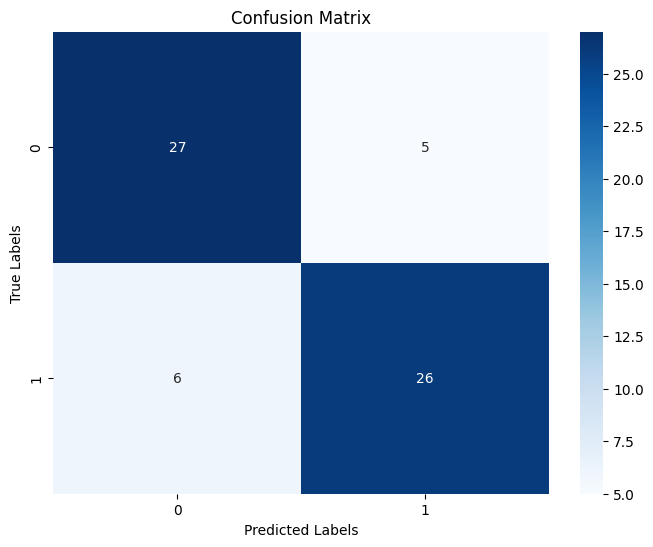

Confusion matrix
27 5
6 26
Accuracy: 0.828125
Precision: 0.8387096774193549
Recall: 0.8125
F1: 0.8253968253968254


In [119]:
lg = LogisticRegression()

lg.fit(X_smt_train, y_smt_train)
y_smt_pred = lg.predict(X_smt_test)

print_metrics(y_smt_test, y_smt_pred)

#### Подбор гиперпарамеров для логистической регрессии

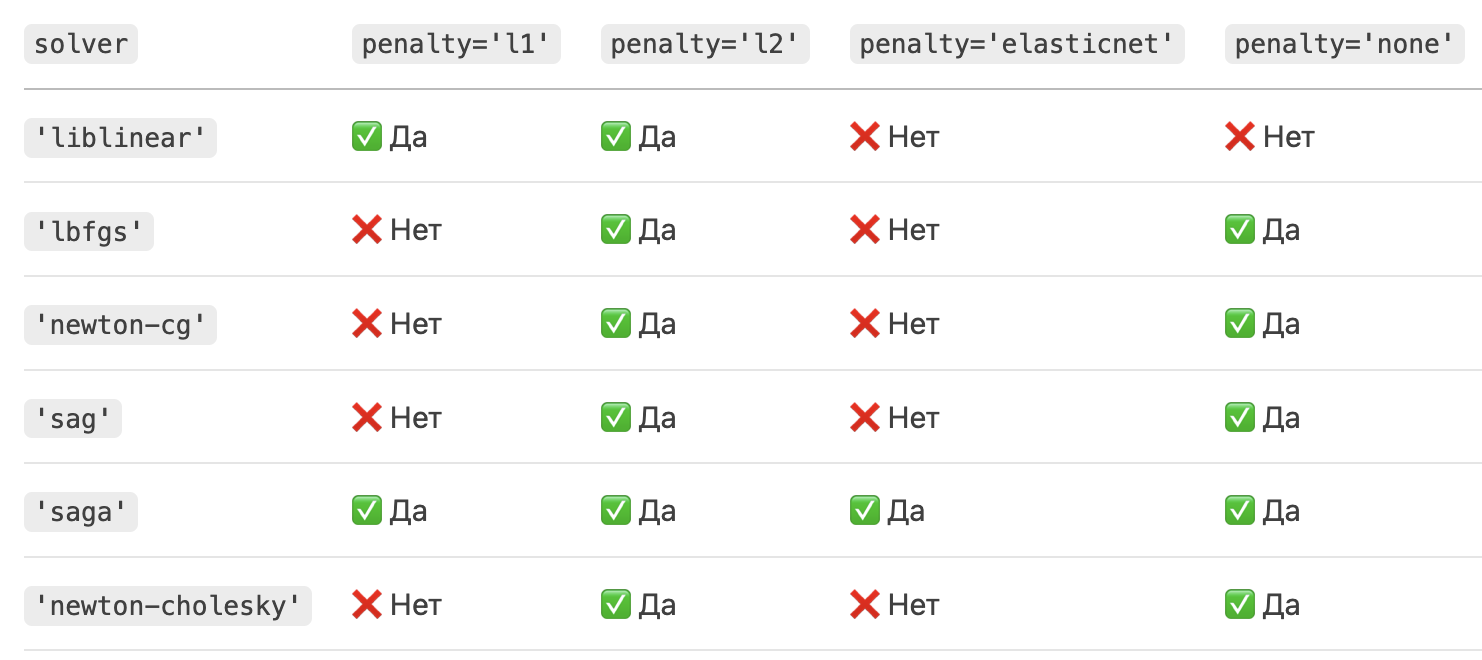

none
[[28  4]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       128
           1       0.86      0.80      0.83       128

    accuracy                           0.84       256
   macro avg       0.84      0.84      0.84       256
weighted avg       0.84      0.84      0.84       256

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.87      0.81      0.84        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



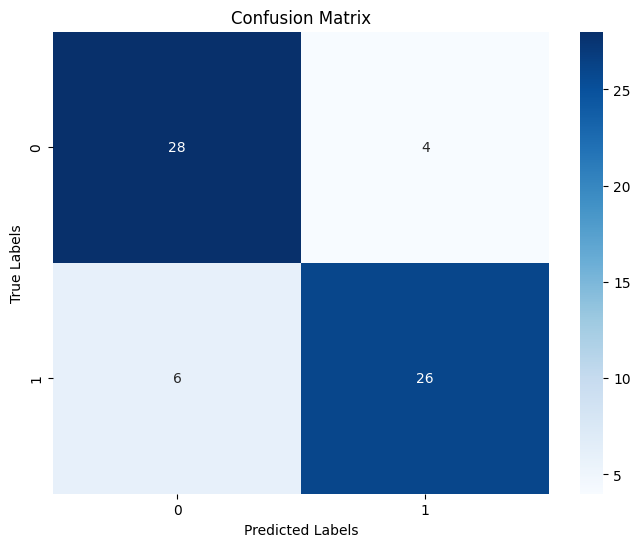

Confusion matrix
28 4
6 26
Accuracy: 0.84375
Precision: 0.8666666666666667
Recall: 0.8125
F1: 0.8387096774193549
Лучшие параметры: {'solver': 'lbfgs'}
Лучший F1: 0.8045120039307451
--------------------------------------------------
none


/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[[28  4]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       128
           1       0.86      0.80      0.83       128

    accuracy                           0.84       256
   macro avg       0.84      0.84      0.84       256
weighted avg       0.84      0.84      0.84       256

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.87      0.81      0.84        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



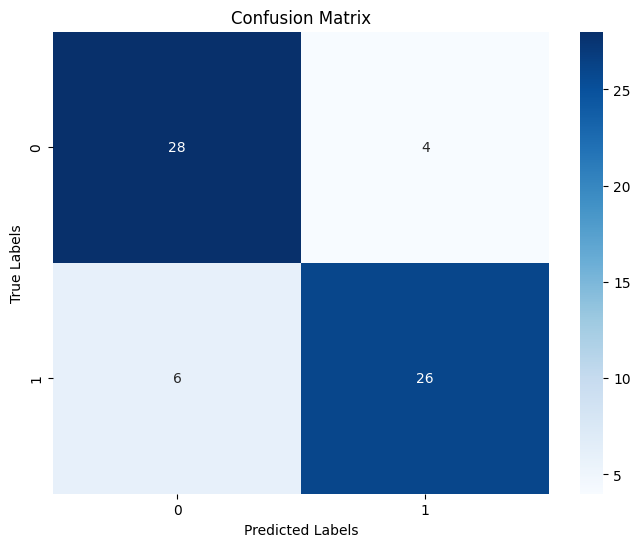

Confusion matrix
28 4
6 26
Accuracy: 0.84375
Precision: 0.8666666666666667
Recall: 0.8125
F1: 0.8387096774193549
Лучшие параметры: {'solver': 'lbfgs'}
Лучший F1: 0.8046003016591252
--------------------------------------------------
----------------------------------------------------------------------------------------------------
l1
[[26  6]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       128
           1       0.86      0.80      0.83       128

    accuracy                           0.83       256
   macro avg       0.83      0.83      0.83       256
weighted avg       0.83      0.83      0.83       256

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        32
           1       0.81      0.81      0.81        32

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted avg       0.81      0.81      0.81   

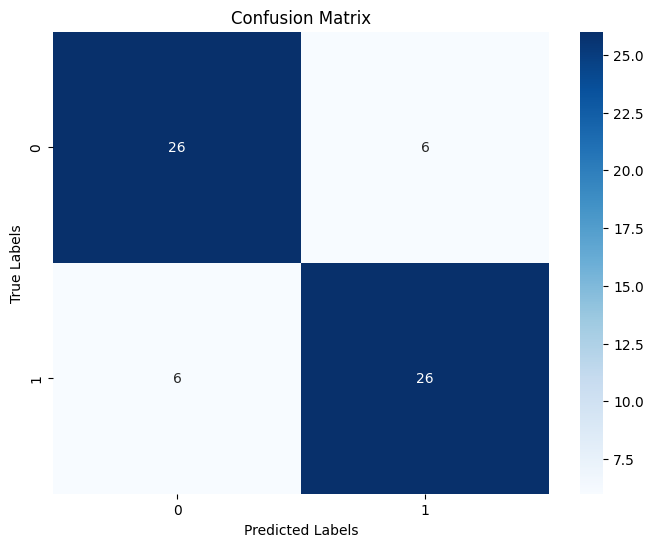

Confusion matrix
26 6
6 26
Accuracy: 0.8125
Precision: 0.8125
Recall: 0.8125
F1: 0.8125
Лучшие параметры: {'C': 0.1, 'solver': 'saga'}
Лучший F1: 0.7962119959260134
--------------------------------------------------
l1
[[26  6]
 [ 5 27]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       128
           1       0.82      0.80      0.81       128

    accuracy                           0.82       256
   macro avg       0.82      0.82      0.82       256
weighted avg       0.82      0.82      0.82       256

              precision    recall  f1-score   support

           0       0.84      0.81      0.83        32
           1       0.82      0.84      0.83        32

    accuracy                           0.83        64
   macro avg       0.83      0.83      0.83        64
weighted avg       0.83      0.83      0.83        64



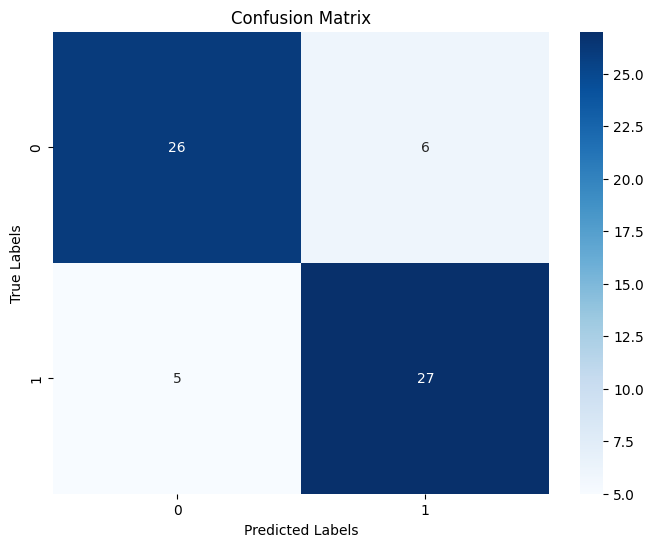

[I 2025-05-07 12:07:19,972] A new study created in memory with name: no-name-2ea88d03-c683-489a-95ac-3a7463a2432c
[I 2025-05-07 12:07:19,979] Trial 0 finished with value: 0.8253968253968254 and parameters: {'C': 1.763376672118166, 'solver': 'saga'}. Best is trial 0 with value: 0.8253968253968254.
[I 2025-05-07 12:07:19,981] Trial 1 finished with value: 0.8125 and parameters: {'C': 3.7040079926788474, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8253968253968254.
[I 2025-05-07 12:07:19,994] Trial 2 finished with value: 0.8253968253968254 and parameters: {'C': 7.481306645858411, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8253968253968254.
[I 2025-05-07 12:07:20,015] Trial 3 finished with value: 0.8253968253968254 and parameters: {'C': 1.3115786267980387, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8253968253968254.
[I 2025-05-07 12:07:20,041] Trial 4 finished with value: 0.8253968253968254 and parameters: {'C': 1.0085389846929425, 'solver': 'saga'}. Best is 

Confusion matrix
26 6
5 27
Accuracy: 0.828125
Precision: 0.8181818181818182
Recall: 0.84375
F1: 0.8307692307692308
Лучшие параметры: {'C': 0.24810409748678125, 'solver': 'liblinear'}
Лучший F1: 0.808446455505279
--------------------------------------------------
l1


[I 2025-05-07 12:07:20,108] Trial 13 finished with value: 0.8387096774193549 and parameters: {'C': 8.462769549064237, 'solver': 'saga'}. Best is trial 13 with value: 0.8387096774193549.
[I 2025-05-07 12:07:20,115] Trial 14 finished with value: 0.8253968253968254 and parameters: {'C': 0.6597463982241396, 'solver': 'saga'}. Best is trial 13 with value: 0.8387096774193549.
[I 2025-05-07 12:07:20,120] Trial 15 finished with value: 0.7741935483870968 and parameters: {'C': 0.04790825300576237, 'solver': 'saga'}. Best is trial 13 with value: 0.8387096774193549.
[I 2025-05-07 12:07:20,132] Trial 16 finished with value: 0.8253968253968254 and parameters: {'C': 2.717204977497335, 'solver': 'saga'}. Best is trial 13 with value: 0.8387096774193549.
[I 2025-05-07 12:07:20,138] Trial 17 finished with value: 0.8125 and parameters: {'C': 0.31609578687453727, 'solver': 'saga'}. Best is trial 13 with value: 0.8387096774193549.
[I 2025-05-07 12:07:20,174] Trial 18 finished with value: 0.8387096774193549 

{'C': 8.462769549064237, 'solver': 'saga'}
[[28  4]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       128
           1       0.85      0.80      0.83       128

    accuracy                           0.83       256
   macro avg       0.83      0.83      0.83       256
weighted avg       0.83      0.83      0.83       256

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.87      0.81      0.84        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



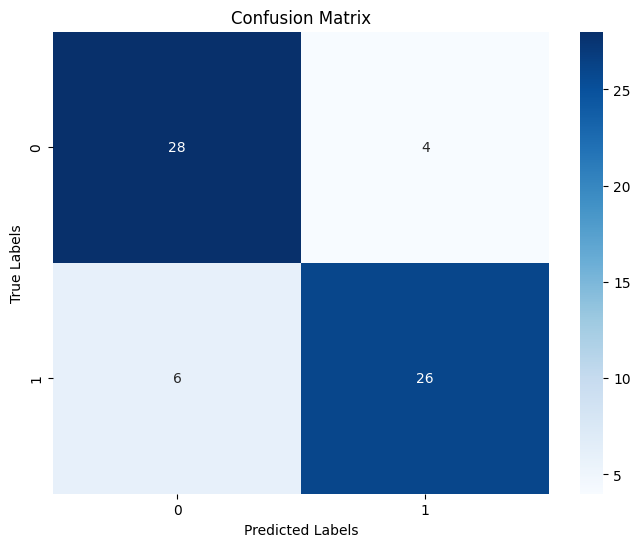

Confusion matrix
28 4
6 26
Accuracy: 0.84375
Precision: 0.8666666666666667
Recall: 0.8125
F1: 0.8387096774193549
----------------------------------------------------------------------------------------------------
l2
[[25  7]
 [ 5 27]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       128
           1       0.83      0.80      0.81       128

    accuracy                           0.82       256
   macro avg       0.82      0.82      0.82       256
weighted avg       0.82      0.82      0.82       256

              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1       0.79      0.84      0.82        32

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted avg       0.81      0.81      0.81        64



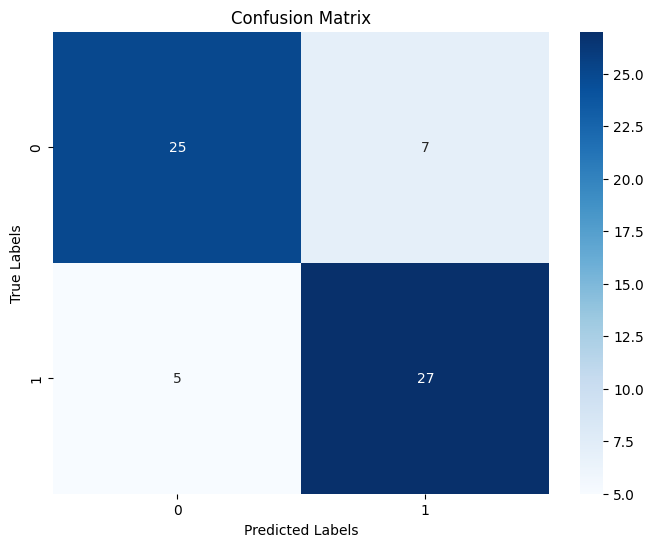

Confusion matrix
25 7
5 27
Accuracy: 0.8125
Precision: 0.7941176470588235
Recall: 0.84375
F1: 0.8181818181818182
Лучшие параметры: {'C': 0.1, 'solver': 'liblinear'}
Лучший F1: 0.804270177789577
--------------------------------------------------
l2
[[26  6]
 [ 5 27]]
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       128
           1       0.85      0.76      0.80       128

    accuracy                           0.81       256
   macro avg       0.82      0.81      0.81       256
weighted avg       0.82      0.81      0.81       256

              precision    recall  f1-score   support

           0       0.84      0.81      0.83        32
           1       0.82      0.84      0.83        32

    accuracy                           0.83        64
   macro avg       0.83      0.83      0.83        64
weighted avg       0.83      0.83      0.83        64



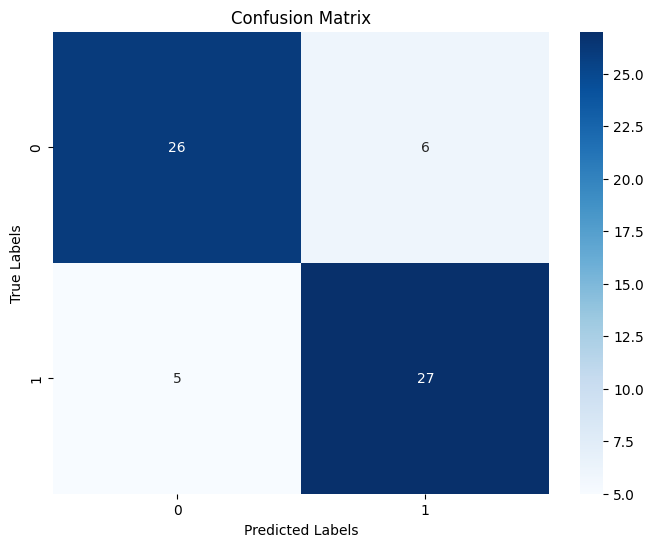

Confusion matrix
26 6
5 27
Accuracy: 0.828125
Precision: 0.8181818181818182
Recall: 0.84375
F1: 0.8307692307692308
Лучшие параметры: {'C': 0.0070689749506246055, 'solver': 'sag'}
Лучший F1: 0.8085218702865762
--------------------------------------------------
----------------------------------------------------------------------------------------------------
elasticnet
[[27  5]
 [ 7 25]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       128
           1       0.86      0.79      0.82       128

    accuracy                           0.83       256
   macro avg       0.83      0.83      0.83       256
weighted avg       0.83      0.83      0.83       256

              precision    recall  f1-score   support

           0       0.79      0.84      0.82        32
           1       0.83      0.78      0.81        32

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted a

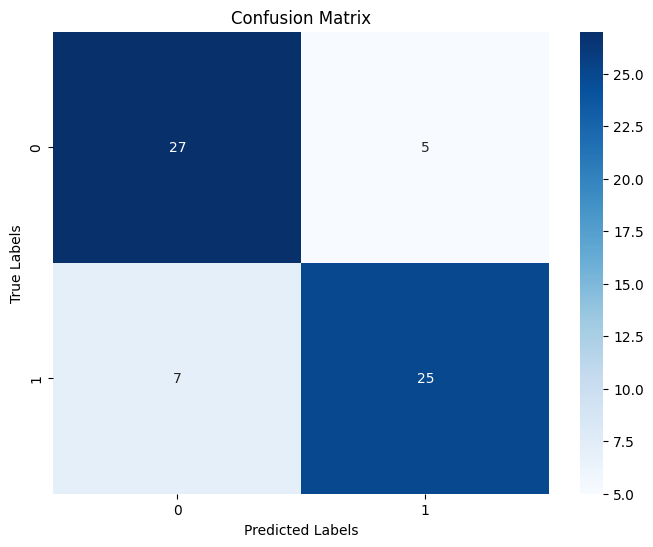

Confusion matrix
27 5
7 25
Accuracy: 0.8125
Precision: 0.8333333333333334
Recall: 0.78125
F1: 0.8064516129032259
Лучшие параметры: {'C': 0.1, 'l1_ratio': 0.2}
Лучший F1: 0.8074936229303358
--------------------------------------------------
elasticnet
[[28  4]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       128
           1       0.87      0.79      0.83       128

    accuracy                           0.84       256
   macro avg       0.84      0.84      0.84       256
weighted avg       0.84      0.84      0.84       256

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.87      0.81      0.84        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



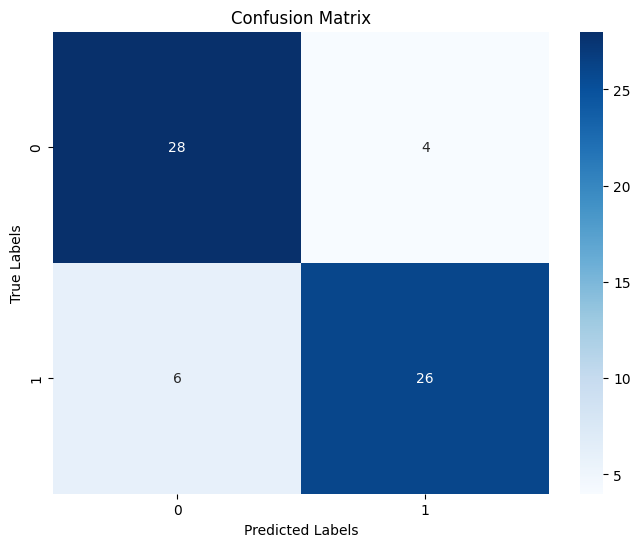

Confusion matrix
28 4
6 26
Accuracy: 0.84375
Precision: 0.8666666666666667
Recall: 0.8125
F1: 0.8387096774193549
Лучшие параметры: {'C': 0.05342937261279776, 'l1_ratio': 0.2912291401980419}
Лучший F1: 0.81236802413273
--------------------------------------------------
----------------------------------------------------------------------------------------------------


In [120]:
regularizations = ['none', 'l1', 'l2', 'elasticnet']

for regularization in regularizations:
    model, params = params_log_regression(regularization, 'grid_search', X_smt_train, X_smt_test, y_smt_train, y_smt_test)
    grid_search = GridSearchCV(model, params, cv=kf, scoring='f1_macro')
    grid_search.fit(X_smt_train, y_smt_train)

    best_model = grid_search.best_estimator_
    y_smt_pred_test = best_model.predict(X_smt_test)
    y_smt_pred_train = best_model.predict(X_smt_train)

    print_metrics(y_smt_test, y_smt_pred_test, y_smt_train, y_smt_pred_train)

    print("Лучшие параметры:", grid_search.best_params_)
    print("Лучший F1:", grid_search.best_score_)

    print('-' * 50)

    model, params = params_log_regression(regularization, 'random_search', X_smt_train, X_smt_test, y_smt_train, y_smt_test)
    random_search = RandomizedSearchCV(model, params, n_iter=20, cv=kf, random_state=42)
    random_search.fit(X_smt_train, y_smt_train)

    best_model = random_search.best_estimator_
    y_smt_pred_test = best_model.predict(X_smt_test)
    y_smt_pred_train = best_model.predict(X_smt_train)

    print_metrics(y_smt_test, y_smt_pred_test, y_smt_train, y_smt_pred_train)

    print("Лучшие параметры:", random_search.best_params_)
    print("Лучший F1:", random_search.best_score_)

    print('-' * 50)

    if regularization == 'l1':

        best_model = params_log_regression(regularization, 'optuna', X_smt_train, X_smt_test, y_smt_train, y_smt_test)

        y_smt_pred_test = best_model.predict(X_smt_test)
        y_smt_pred_train = best_model.predict(X_smt_train)

        print_metrics(y_smt_test, y_smt_pred_test, y_smt_train, y_smt_pred_train)

    print('-' * 100)

### kNN

[[28  4]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.87      0.81      0.84        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



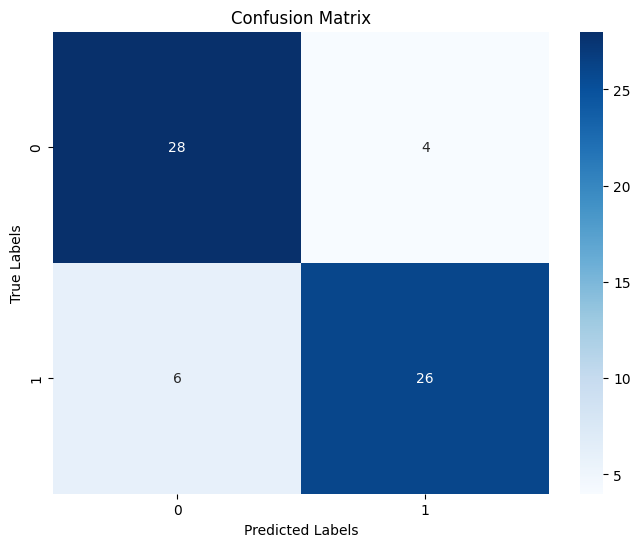

Confusion matrix
28 4
6 26
Accuracy: 0.84375
Precision: 0.8666666666666667
Recall: 0.8125
F1: 0.8387096774193549


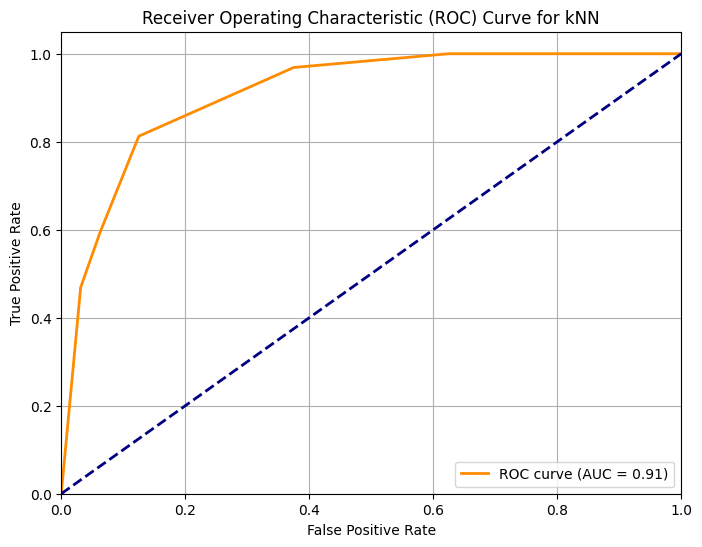

In [121]:
knn = KNeighborsClassifier()

knn.fit(X_smt_train, y_smt_train)
y_smt_pred = knn.predict(X_smt_test)

y_scores = knn.predict_proba(X_smt_test)[:, 1]

print_metrics(y_smt_test, y_smt_pred, y_sores=y_scores)

#### Подбор гиперпарамеров для k ближайших соседей

ball_tree
[[26  6]
 [ 4 28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        32
           1       0.82      0.88      0.85        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



/Users/macbook/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


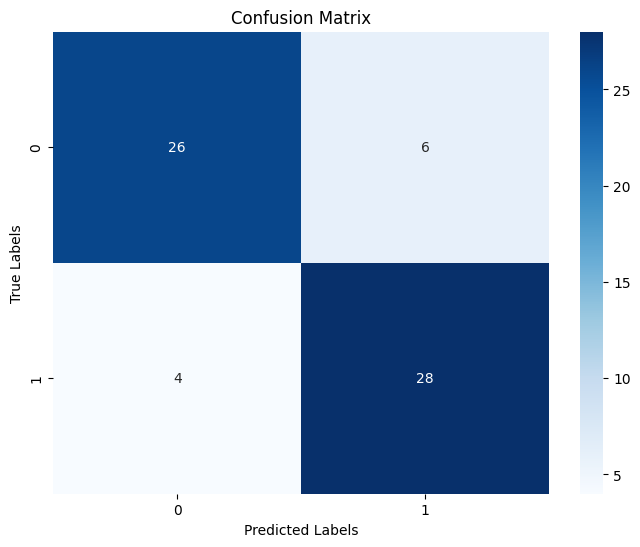

Confusion matrix
26 6
4 28
Accuracy: 0.84375
Precision: 0.8235294117647058
Recall: 0.875
F1: 0.8484848484848485
Лучшие параметры: {'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Лучший F1: 0.8392859408236767
--------------------------------------------------
elasticnet
[[28  4]
 [ 8 24]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.78      0.88      0.82        32
           1       0.86      0.75      0.80        32

    accuracy                           0.81        64
   macro avg       0.82      0.81      0.81        64
weighted avg       0.82      0.81      0.81        64



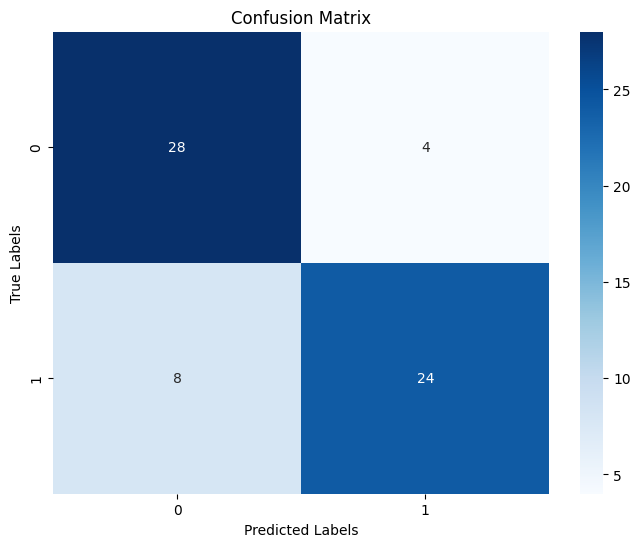

Confusion matrix
28 4
8 24
Accuracy: 0.8125
Precision: 0.8571428571428571
Recall: 0.75
F1: 0.7999999999999999
Лучшие параметры: {'metric': 'hamming', 'n_neighbors': 4, 'weights': 'distance'}
Лучший F1: 0.8263193479220629
----------------------------------------------------------------------------------------------------
kd_tree
[[26  6]
 [ 3 29]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.90      0.81      0.85        32
           1       0.83      0.91      0.87        32

    accuracy                           0.86        64
   macro avg       0.86      0.86      0.86        64
weighted avg       0.86      0.86      0.86        6

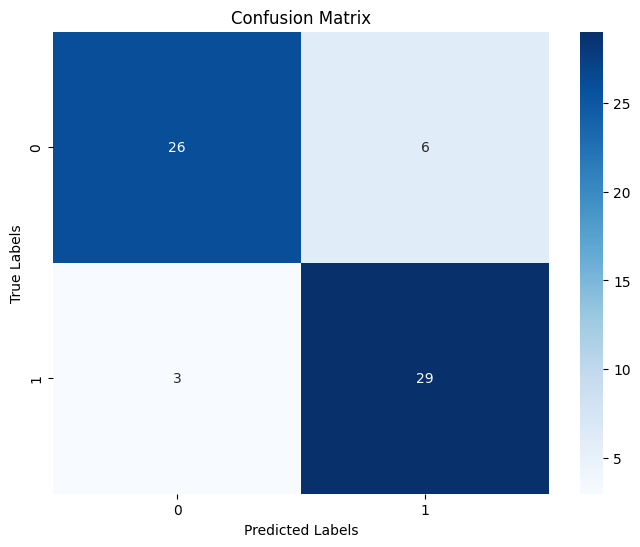

Confusion matrix
26 6
3 29
Accuracy: 0.859375
Precision: 0.8285714285714286
Recall: 0.90625
F1: 0.8656716417910447
Лучшие параметры: {'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Лучший F1: 0.8078953260865147
--------------------------------------------------
elasticnet
[[28  4]
 [ 8 24]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.78      0.88      0.82        32
           1       0.86      0.75      0.80        32

    accuracy                           0.81        64
   macro avg       0.82      0.81      0.81        64
weighted avg       0.82      0.81      0.81        64



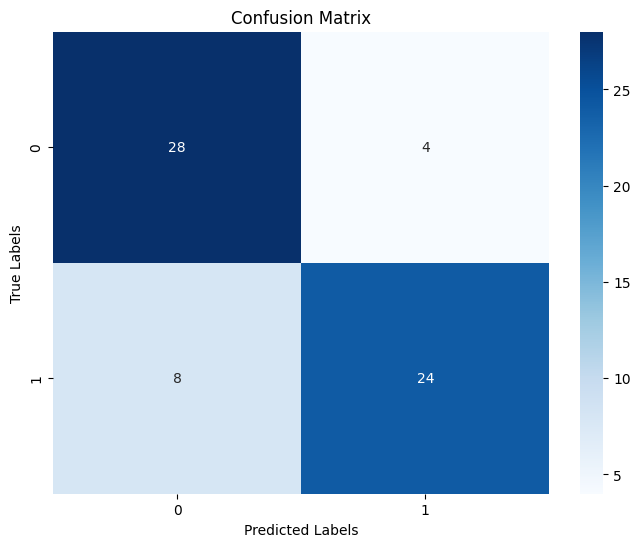

Confusion matrix
28 4
8 24
Accuracy: 0.8125
Precision: 0.8571428571428571
Recall: 0.75
F1: 0.7999999999999999
Лучшие параметры: {'metric': 'hamming', 'n_neighbors': 4, 'weights': 'distance'}
Лучший F1: 0.8263193479220629
----------------------------------------------------------------------------------------------------
brute
[[26  6]
 [ 4 28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        32
           1       0.82      0.88      0.85        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64


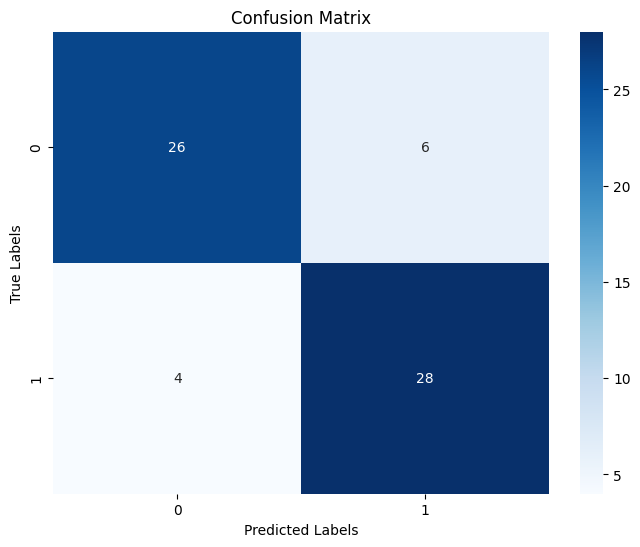

Confusion matrix
26 6
4 28
Accuracy: 0.84375
Precision: 0.8235294117647058
Recall: 0.875
F1: 0.8484848484848485
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Лучший F1: 0.8392859408236767
--------------------------------------------------
elasticnet
[[28  4]
 [ 8 24]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.78      0.88      0.82        32
           1       0.86      0.75      0.80        32

    accuracy                           0.81        64
   macro avg       0.82      0.81      0.81        64
weighted avg       0.82      0.81      0.81        64



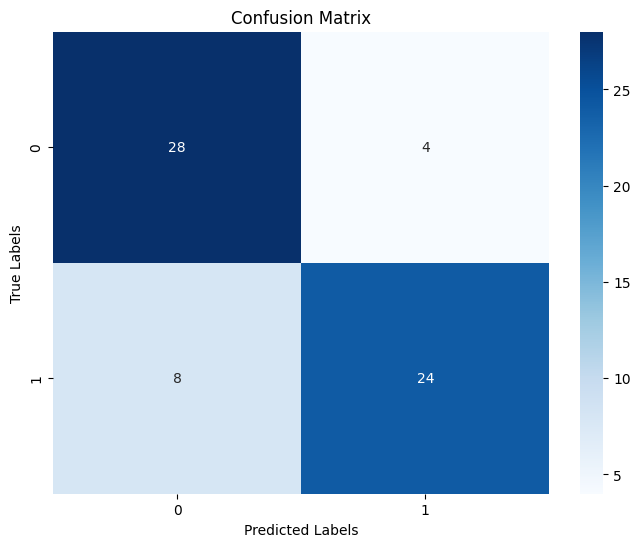

Confusion matrix
28 4
8 24
Accuracy: 0.8125
Precision: 0.8571428571428571
Recall: 0.75
F1: 0.7999999999999999
Лучшие параметры: {'metric': 'hamming', 'n_neighbors': 4, 'weights': 'distance'}
Лучший F1: 0.8263193479220629
----------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ball_tree
[[26  6]
 [ 4 28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        32
           1

/Users/macbook/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


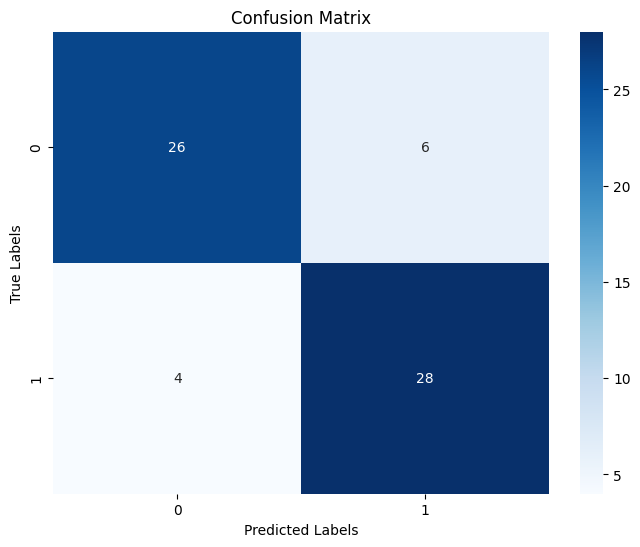

Confusion matrix
26 6
4 28
Accuracy: 0.84375
Precision: 0.8235294117647058
Recall: 0.875
F1: 0.8484848484848485
Лучшие параметры: {'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Лучший F1: 0.8392859408236767
--------------------------------------------------
elasticnet
[[26  6]
 [ 4 28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        32
           1       0.82      0.88      0.85        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



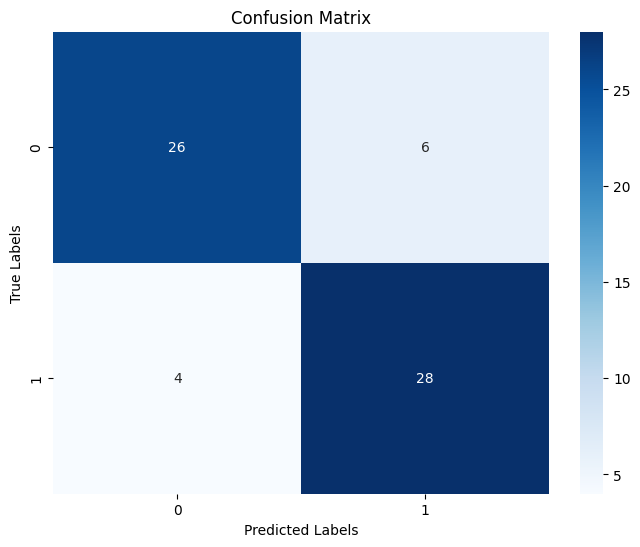

Confusion matrix
26 6
4 28
Accuracy: 0.84375
Precision: 0.8235294117647058
Recall: 0.875
F1: 0.8484848484848485
Лучшие параметры: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Лучший F1: 0.8352976859506906
----------------------------------------------------------------------------------------------------
kd_tree
[[26  6]
 [ 3 29]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.90      0.81      0.85        32
           1       0.83      0.91      0.87        32

    accuracy                           0.86        64
   macro avg       0.86      0.86      0.86        64
weighted avg       0.86      0.86      0.86        64



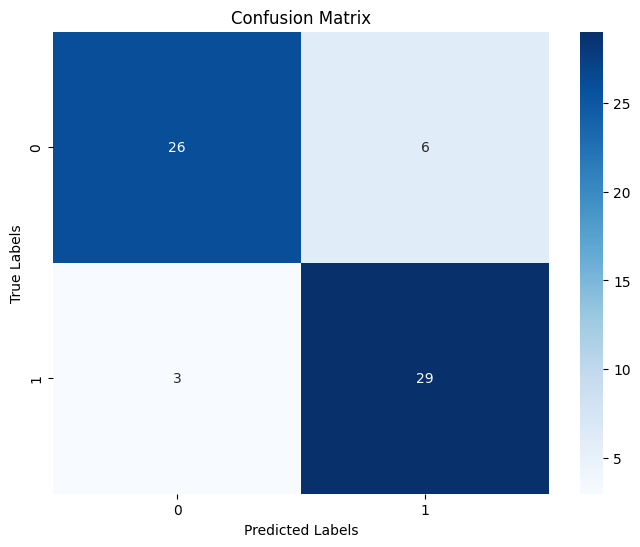

Confusion matrix
26 6
3 29
Accuracy: 0.859375
Precision: 0.8285714285714286
Recall: 0.90625
F1: 0.8656716417910447
Лучшие параметры: {'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
Лучший F1: 0.8078953260865147
--------------------------------------------------
elasticnet
[[26  6]
 [ 4 28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        32
           1       0.82      0.88      0.85        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



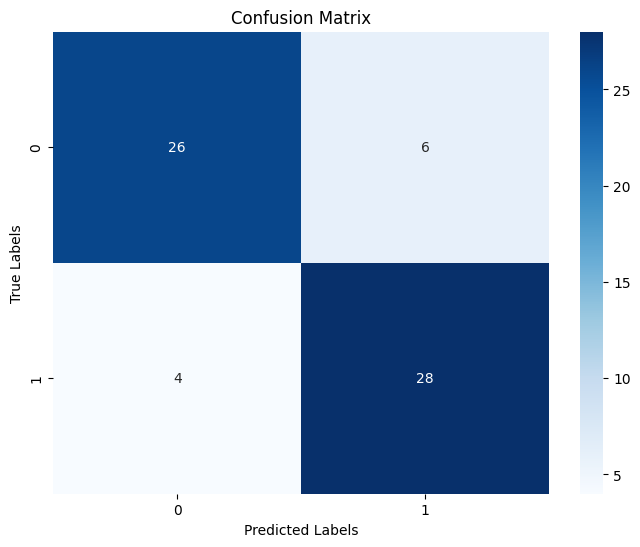

Confusion matrix
26 6
4 28
Accuracy: 0.84375
Precision: 0.8235294117647058
Recall: 0.875
F1: 0.8484848484848485
Лучшие параметры: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Лучший F1: 0.8352976859506906
----------------------------------------------------------------------------------------------------
brute
[[26  6]
 [ 4 28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        32
           1       0.82      0.88      0.85        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



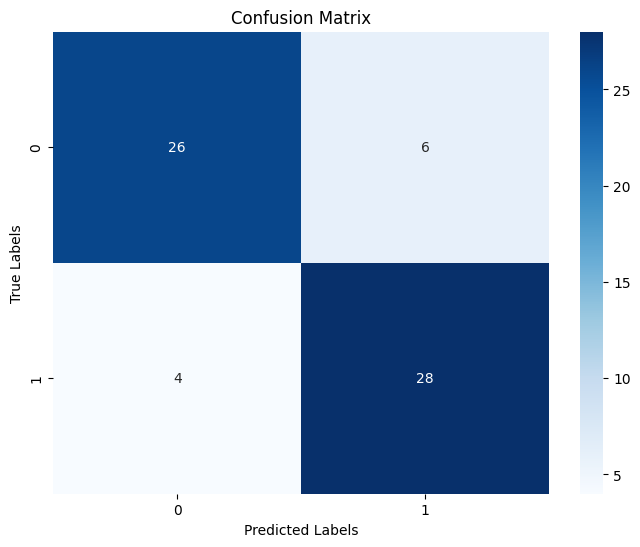

Confusion matrix
26 6
4 28
Accuracy: 0.84375
Precision: 0.8235294117647058
Recall: 0.875
F1: 0.8484848484848485
Лучшие параметры: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Лучший F1: 0.8392859408236767
--------------------------------------------------
elasticnet
[[26  6]
 [ 4 28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        32
           1       0.82      0.88      0.85        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



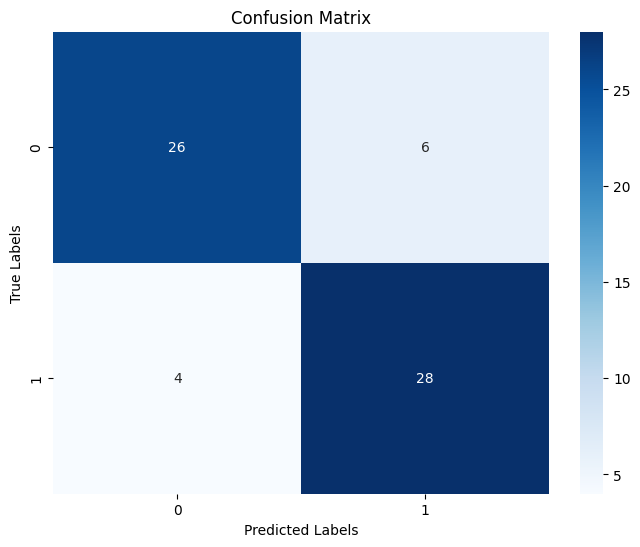

Confusion matrix
26 6
4 28
Accuracy: 0.84375
Precision: 0.8235294117647058
Recall: 0.875
F1: 0.8484848484848485
Лучшие параметры: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Лучший F1: 0.8352976859506906
----------------------------------------------------------------------------------------------------


In [122]:
algorithms = ['ball_tree', 'kd_tree', 'brute']

for algorithm in algorithms:
    model, params = params_knn_withoiut_minkowski(algorithm, 'grid_search')
    grid_search = GridSearchCV(model, params, cv=kf, scoring='f1_macro')
    grid_search.fit(X_smt_train, y_smt_train)

    best_model = grid_search.best_estimator_
    y_smt_pred_test = best_model.predict(X_smt_test)
    y_smt_pred_train = best_model.predict(X_smt_train)

    print_metrics(y_smt_test, y_smt_pred_test, y_smt_train, y_smt_pred_train)

    print("Лучшие параметры:", grid_search.best_params_)
    print("Лучший F1:", grid_search.best_score_)
    print('-' * 50)

    model, params = params_knn_withoiut_minkowski(regularization, 'random_search')
    random_search = RandomizedSearchCV(model, params, n_iter=20, cv=kf, random_state=42, scoring='f1_macro')
    random_search.fit(X_smt_train, y_smt_train)

    best_model = random_search.best_estimator_
    y_smt_pred_test = best_model.predict(X_smt_test)
    y_smt_pred_train = best_model.predict(X_smt_train)

    print_metrics(y_smt_test, y_smt_pred_test, y_smt_train, y_smt_pred_train)

    print("Лучшие параметры:", random_search.best_params_)
    print("Лучший F1:", random_search.best_score_)

    print('-' * 100)

print('-' * 200)

for algorithm in algorithms:
    model, params = params_knn_with_minkowski(algorithm, 'grid_search')
    grid_search = GridSearchCV(model, params, cv=kf, scoring='f1_macro')
    grid_search.fit(X_smt_train, y_smt_train)

    best_model = grid_search.best_estimator_
    y_smt_pred_test = best_model.predict(X_smt_test)
    y_smt_pred_train = best_model.predict(X_smt_train)

    print_metrics(y_smt_test, y_smt_pred_test, y_smt_train, y_smt_pred_train)

    print("Лучшие параметры:", grid_search.best_params_)
    print("Лучший F1:", grid_search.best_score_)
    print('-' * 50)

    model, params = params_knn_with_minkowski(regularization, 'random_search')
    random_search = RandomizedSearchCV(model, params, n_iter=20, cv=kf, random_state=42, scoring='f1_macro')
    random_search.fit(X_smt_train, y_smt_train)

    best_model = random_search.best_estimator_
    y_smt_pred_test = best_model.predict(X_smt_test)
    y_smt_pred_train = best_model.predict(X_smt_train)

    print_metrics(y_smt_test, y_smt_pred_test, y_smt_train, y_smt_pred_train)

    print("Лучшие параметры:", random_search.best_params_)
    print("Лучший F1:", random_search.best_score_)

    print('-' * 100)

### Naive Bayes

[[28  4]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.87      0.81      0.84        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



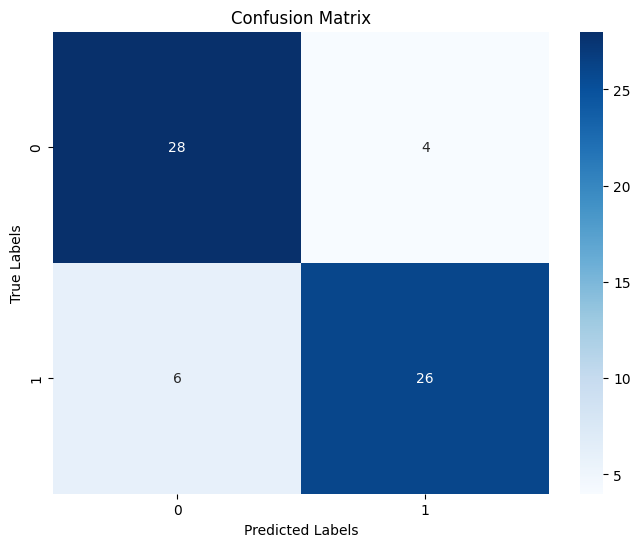

Confusion matrix
28 4
6 26
Accuracy: 0.84375
Precision: 0.8666666666666667
Recall: 0.8125
F1: 0.8387096774193549


In [123]:
nb = GaussianNB()

nb.fit(X_smt_train, y_smt_train)
y_smt_pred = nb.predict(X_smt_test)

print_metrics(y_smt_test, y_smt_pred)

#### Подбор гиперпарамеров для GaussianNB

[[28  4]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       128
           1       0.84      0.76      0.80       128

    accuracy                           0.80       256
   macro avg       0.81      0.80      0.80       256
weighted avg       0.81      0.80      0.80       256

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.87      0.81      0.84        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



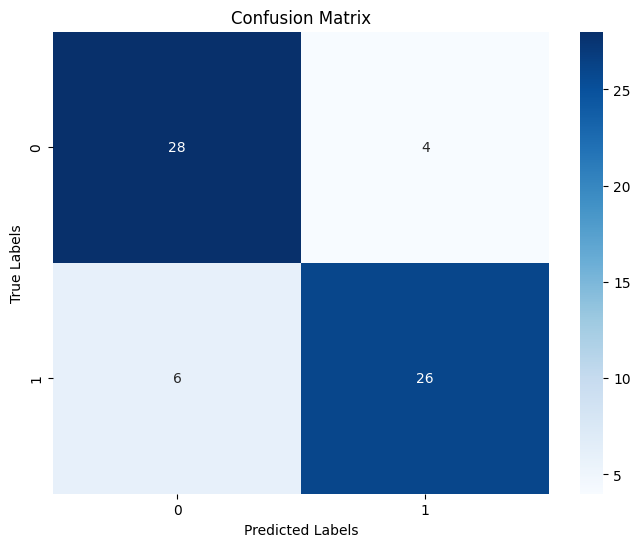

Confusion matrix
28 4
6 26
Accuracy: 0.84375
Precision: 0.8666666666666667
Recall: 0.8125
F1: 0.8387096774193549
Лучшие параметры: {'var_smoothing': 1e-15}
Лучший F1: 0.7917927642930573
--------------------------------------------------
[[28  4]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       128
           1       0.84      0.76      0.80       128

    accuracy                           0.80       256
   macro avg       0.81      0.80      0.80       256
weighted avg       0.81      0.80      0.80       256

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.87      0.81      0.84        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



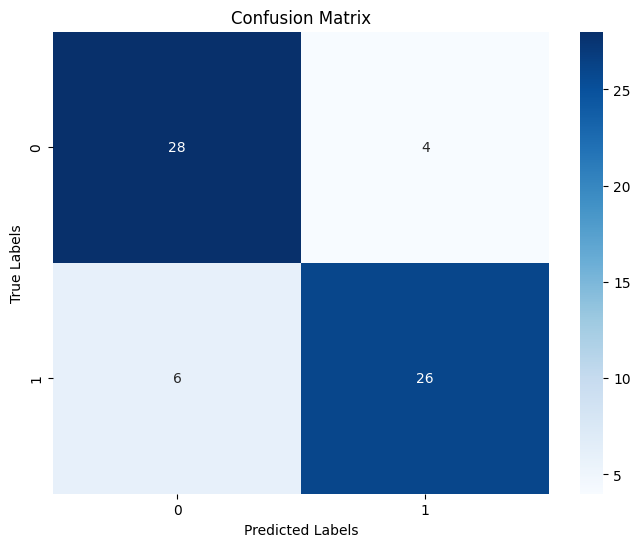

Confusion matrix
28 4
6 26
Accuracy: 0.84375
Precision: 0.8666666666666667
Recall: 0.8125
F1: 0.8387096774193549
Лучшие параметры: {'var_smoothing': 3.1223488672887815e-11}
Лучший F1: 0.7927601809954751
----------------------------------------------------------------------------------------------------


In [124]:
params_grid_search = {
    'var_smoothing': [1e-15, 1e-12, 1e-9, 1e-6, 1e-3]
}

params_random_search = {
    'var_smoothing': loguniform(1e-15, 1e-3)
}

grid_search = GridSearchCV(nb, params_grid_search, cv=kf, scoring='f1_macro')
grid_search.fit(X_smt_train, y_smt_train)

best_model = grid_search.best_estimator_
y_smt_pred_test = best_model.predict(X_smt_test)
y_smt_pred_train = best_model.predict(X_smt_train)

print_metrics(y_smt_test, y_smt_pred_test, y_smt_train, y_smt_pred_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1:", grid_search.best_score_)

plt.show()
print('-' * 50)

random_search = RandomizedSearchCV(nb, params_random_search, n_iter=20, cv=kf, random_state=42)
random_search.fit(X_smt_train, y_smt_train)

best_model = random_search.best_estimator_
y_smt_pred_test = best_model.predict(X_smt_test)
y_smt_pred_train = best_model.predict(X_smt_train)

print_metrics(y_smt_test, y_smt_pred_test, y_smt_train, y_smt_pred_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучший F1:", random_search.best_score_)

print('-' * 100)

### SVM

In [125]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

linear
[[28  4]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.87      0.81      0.84        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



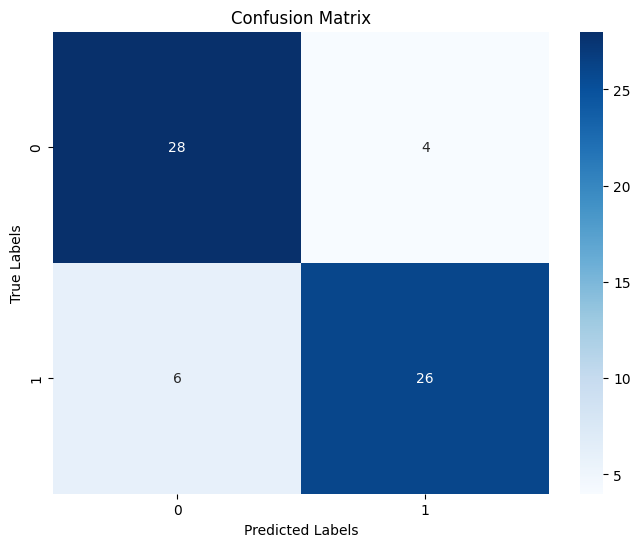

Confusion matrix
28 4
6 26
Accuracy: 0.84375
Precision: 0.8666666666666667
Recall: 0.8125
F1: 0.8387096774193549
poly
[[28  4]
 [11 21]]
              precision    recall  f1-score   support

           0       0.72      0.88      0.79        32
           1       0.84      0.66      0.74        32

    accuracy                           0.77        64
   macro avg       0.78      0.77      0.76        64
weighted avg       0.78      0.77      0.76        64



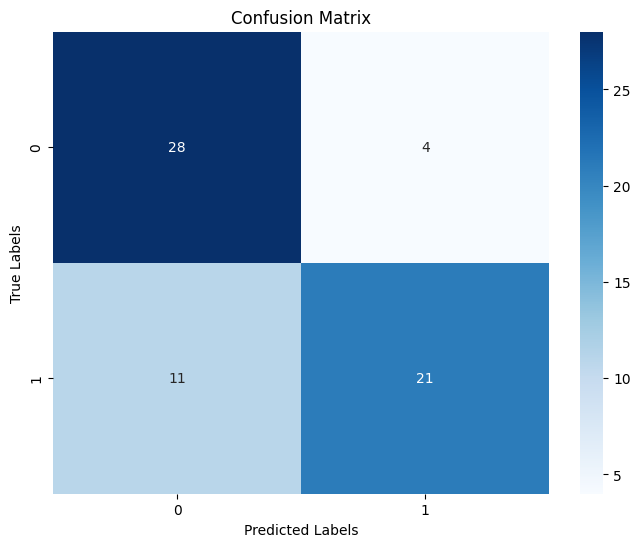

Confusion matrix
28 4
11 21
Accuracy: 0.765625
Precision: 0.84
Recall: 0.65625
F1: 0.736842105263158
rbf
[[28  4]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.87      0.81      0.84        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



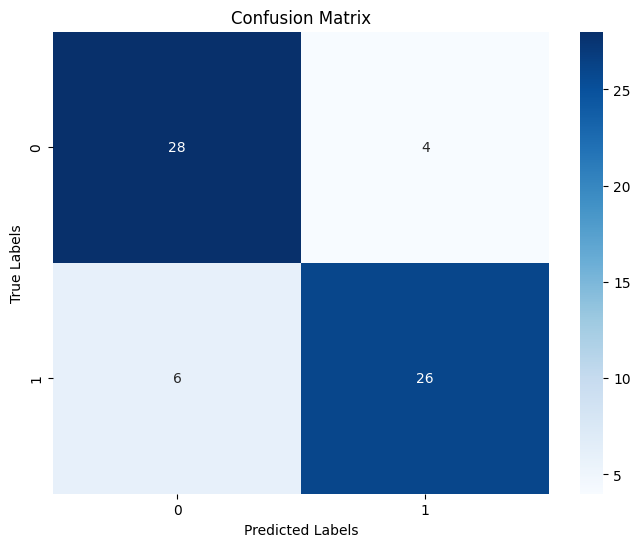

Confusion matrix
28 4
6 26
Accuracy: 0.84375
Precision: 0.8666666666666667
Recall: 0.8125
F1: 0.8387096774193549
sigmoid
[[29  3]
 [ 8 24]]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84        32
           1       0.89      0.75      0.81        32

    accuracy                           0.83        64
   macro avg       0.84      0.83      0.83        64
weighted avg       0.84      0.83      0.83        64



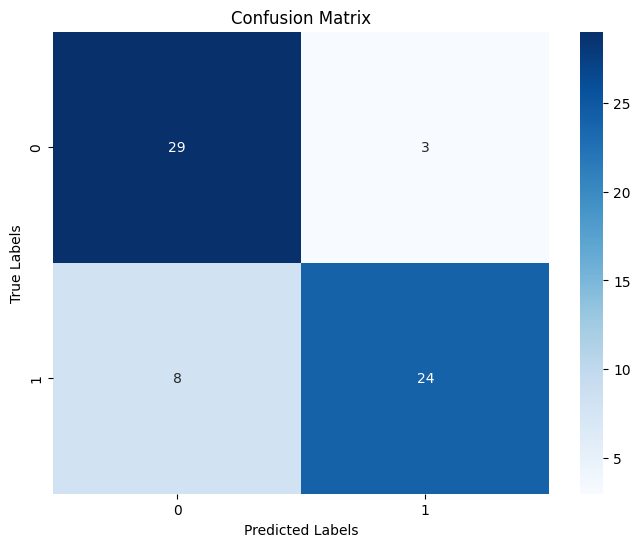

Confusion matrix
29 3
8 24
Accuracy: 0.828125
Precision: 0.8888888888888888
Recall: 0.75
F1: 0.8135593220338982


In [126]:
for kernel in kernels:
    print(kernel)
    svm = SVC(kernel=kernel)

    svm.fit(X_smt_train, y_smt_train)
    y_smt_pred = svm.predict(X_smt_test)

    print_metrics(y_smt_test, y_smt_pred)

    plt.show()
    

#### Подбор гиперпарамеров для SVM

In [127]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'exponential']

In [128]:
def exponential_kernel(X, Y, sigma=1.0):
            return np.exp(-np.linalg.norm(X[:, np.newaxis] - Y, axis=2) / sigma)

linear
[[29  3]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       128
           1       0.90      0.74      0.81       128

    accuracy                           0.83       256
   macro avg       0.84      0.83      0.83       256
weighted avg       0.84      0.83      0.83       256

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        32
           1       0.90      0.81      0.85        32

    accuracy                           0.86        64
   macro avg       0.86      0.86      0.86        64
weighted avg       0.86      0.86      0.86        64



/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packag

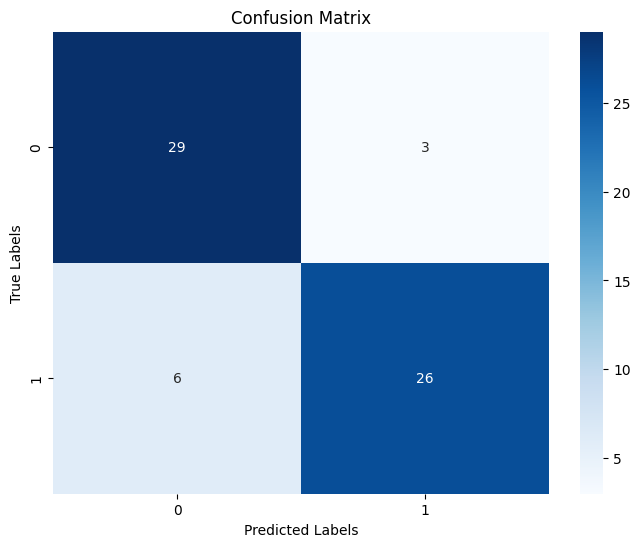

Confusion matrix
29 3
6 26
Accuracy: 0.859375
Precision: 0.896551724137931
Recall: 0.8125
F1: 0.8524590163934426
Лучшие параметры: {'C': 0.01}
Лучший F1: 0.8097404436018418
----------------------------------------------------------------------------------------------------


/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packag

[[31  1]
 [ 8 24]]
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       128
           1       0.91      0.70      0.79       128

    accuracy                           0.81       256
   macro avg       0.83      0.81      0.81       256
weighted avg       0.83      0.81      0.81       256

              precision    recall  f1-score   support

           0       0.79      0.97      0.87        32
           1       0.96      0.75      0.84        32

    accuracy                           0.86        64
   macro avg       0.88      0.86      0.86        64
weighted avg       0.88      0.86      0.86        64



/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


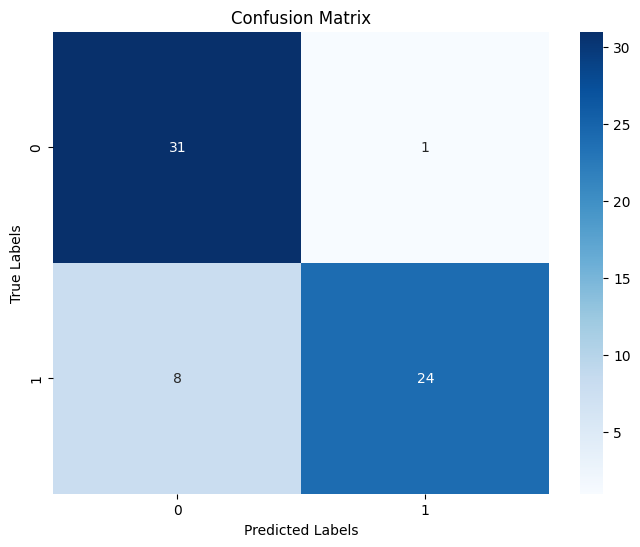

Confusion matrix
31 1
8 24
Accuracy: 0.859375
Precision: 0.96
Recall: 0.75
F1: 0.8421052631578947
Лучшие параметры: {'C': 0.003464572636889783}
Лучший F1: 0.8177480771049321
----------------------------------------------------------------------------------------------------
poly


/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packag

[[31  1]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       128
           1       0.91      0.73      0.81       128

    accuracy                           0.83       256
   macro avg       0.84      0.83      0.83       256
weighted avg       0.84      0.83      0.83       256

              precision    recall  f1-score   support

           0       0.84      0.97      0.90        32
           1       0.96      0.81      0.88        32

    accuracy                           0.89        64
   macro avg       0.90      0.89      0.89        64
weighted avg       0.90      0.89      0.89        64



/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


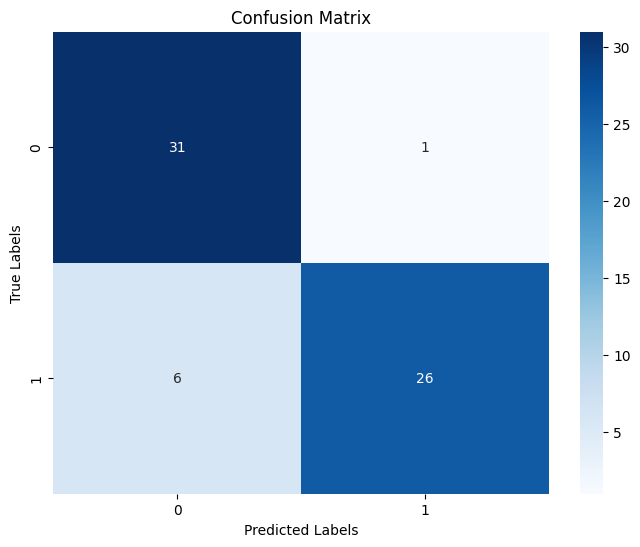

/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Confusion matrix
31 1
6 26
Accuracy: 0.890625
Precision: 0.9629629629629629
Recall: 0.8125
F1: 0.8813559322033898
Лучшие параметры: {'C': 1, 'coef0': 0.5, 'degree': 3, 'gamma': 0.01}
Лучший F1: 0.8133191125902913
----------------------------------------------------------------------------------------------------


/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[[27  5]
 [ 8 24]]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       128
           1       0.91      0.84      0.87       128

    accuracy                           0.88       256
   macro avg       0.88      0.88      0.88       256
weighted avg       0.88      0.88      0.88       256

              precision    recall  f1-score   support

           0       0.77      0.84      0.81        32
           1       0.83      0.75      0.79        32

    accuracy                           0.80        64
   macro avg       0.80      0.80      0.80        64
weighted avg       0.80      0.80      0.80        64



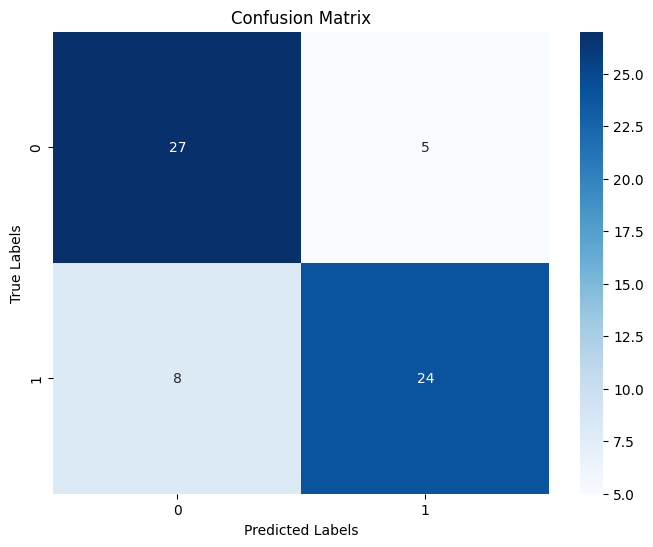

Confusion matrix
27 5
8 24
Accuracy: 0.796875
Precision: 0.8275862068965517
Recall: 0.75
F1: 0.7868852459016394
Лучшие параметры: {'C': 0.4881659357801558, 'coef0': 0.9259025749174763, 'degree': 2, 'gamma': 0.2583508894958044}
Лучший F1: 0.7962544940569357
----------------------------------------------------------------------------------------------------
rbf
[[26  6]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       128
           1       0.88      0.78      0.83       128

    accuracy                           0.84       256
   macro avg       0.84      0.84      0.84       256
weighted avg       0.84      0.84      0.84       256

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        32
           1       0.81      0.81      0.81        32

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted avg       0

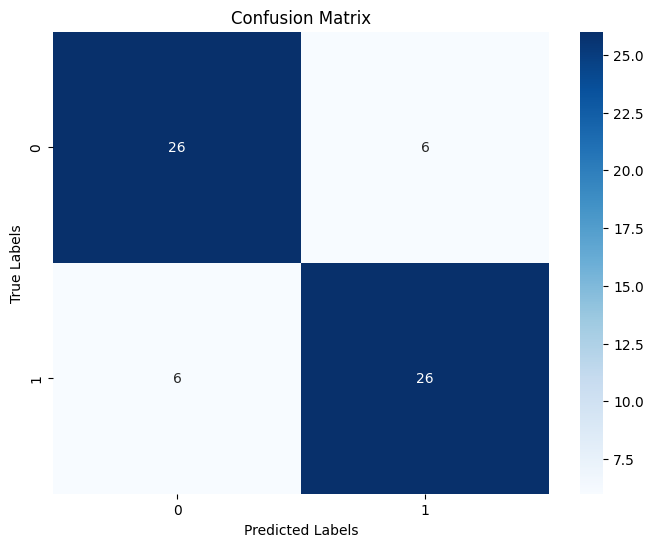

Confusion matrix
26 6
6 26
Accuracy: 0.8125
Precision: 0.8125
Recall: 0.8125
F1: 0.8125
Лучшие параметры: {'C': 0.1, 'gamma': 0.1}
Лучший F1: 0.8111008458552791
----------------------------------------------------------------------------------------------------
[[25  7]
 [ 7 25]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       128
           1       0.92      0.85      0.89       128

    accuracy                           0.89       256
   macro avg       0.89      0.89      0.89       256
weighted avg       0.89      0.89      0.89       256

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        32
           1       0.78      0.78      0.78        32

    accuracy                           0.78        64
   macro avg       0.78      0.78      0.78        64
weighted avg       0.78      0.78      0.78        64



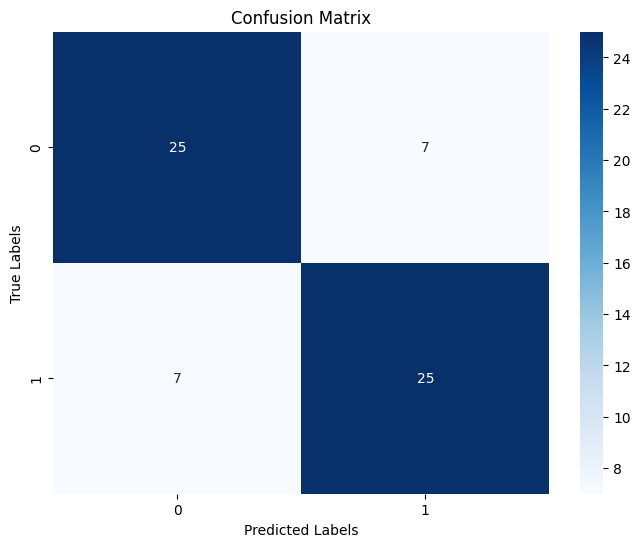

Confusion matrix
25 7
7 25
Accuracy: 0.78125
Precision: 0.78125
Recall: 0.78125
F1: 0.78125
Лучшие параметры: {'C': 0.3770630868179721, 'gamma': 0.2263473454821519}
Лучший F1: 0.7924818797055994
----------------------------------------------------------------------------------------------------
sigmoid
[[30  2]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       128
           1       0.90      0.73      0.81       128

    accuracy                           0.83       256
   macro avg       0.84      0.83      0.83       256
weighted avg       0.84      0.83      0.83       256

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        32
           1       0.93      0.81      0.87        32

    accuracy                           0.88        64
   macro avg       0.88      0.88      0.87        64
weighted avg       0.88      0.88      0.87        64



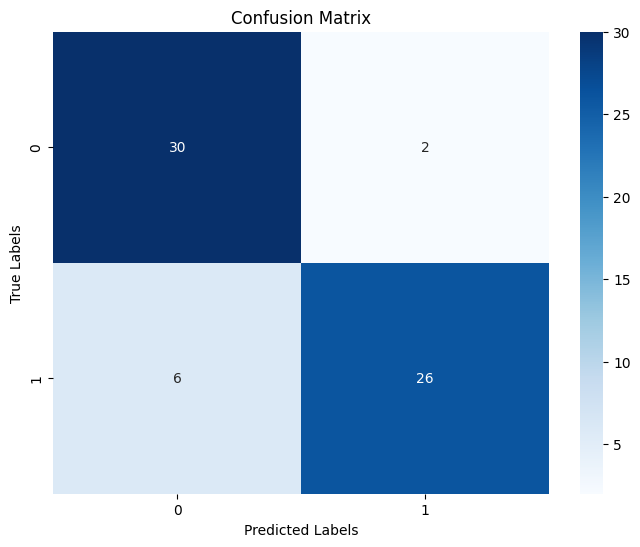

Confusion matrix
30 2
6 26
Accuracy: 0.875
Precision: 0.9285714285714286
Recall: 0.8125
F1: 0.8666666666666666
Лучшие параметры: {'C': 1, 'coef0': 0.5, 'gamma': 0.01}
Лучший F1: 0.8218317778630084
----------------------------------------------------------------------------------------------------
[[28  4]
 [ 6 26]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       128
           1       0.85      0.77      0.81       128

    accuracy                           0.82       256
   macro avg       0.82      0.82      0.82       256
weighted avg       0.82      0.82      0.82       256

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.87      0.81      0.84        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



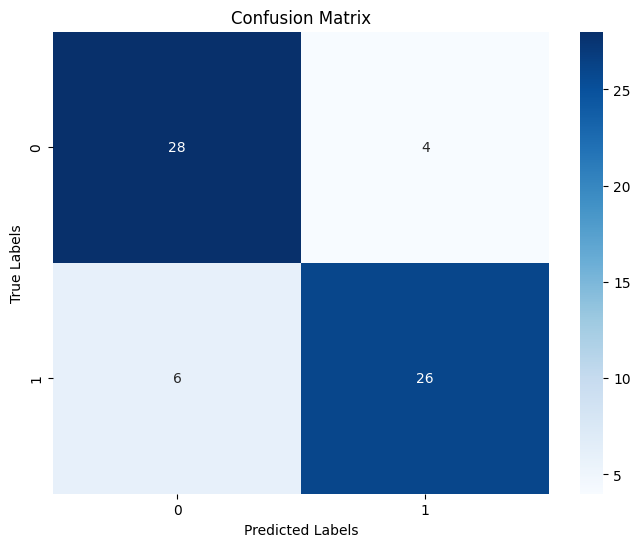

Confusion matrix
28 4
6 26
Accuracy: 0.84375
Precision: 0.8666666666666667
Recall: 0.8125
F1: 0.8387096774193549
Лучшие параметры: {'C': 3.2427805449158584, 'coef0': 0.9643200358668067, 'gamma': 0.04557029284023612}
Лучший F1: 0.8114596805588749
----------------------------------------------------------------------------------------------------
exponential
[[23  9]
 [ 2 30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.92      0.72      0.81        32
           1       0.77      0.94      0.85        32

    accuracy                           0.83        64
   macro avg       0.84      0.83      0.83        64
weighted avg       0.84

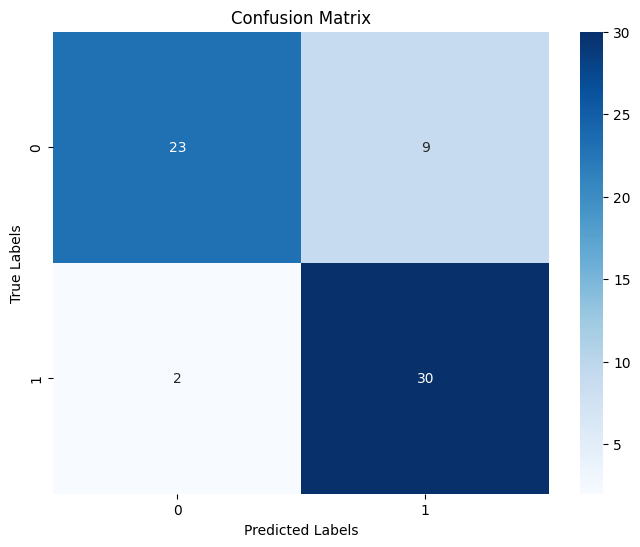

Confusion matrix
23 9
2 30
Accuracy: 0.828125
Precision: 0.7692307692307693
Recall: 0.9375
F1: 0.8450704225352113
Лучшие параметры: {'C': 1}
Лучший F1: 0.7830925501482499
----------------------------------------------------------------------------------------------------
[[23  9]
 [ 2 30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

              precision    recall  f1-score   support

           0       0.92      0.72      0.81        32
           1       0.77      0.94      0.85        32

    accuracy                           0.83        64
   macro avg       0.84      0.83      0.83        64
weighted avg       0.84      0.83      0.83        64



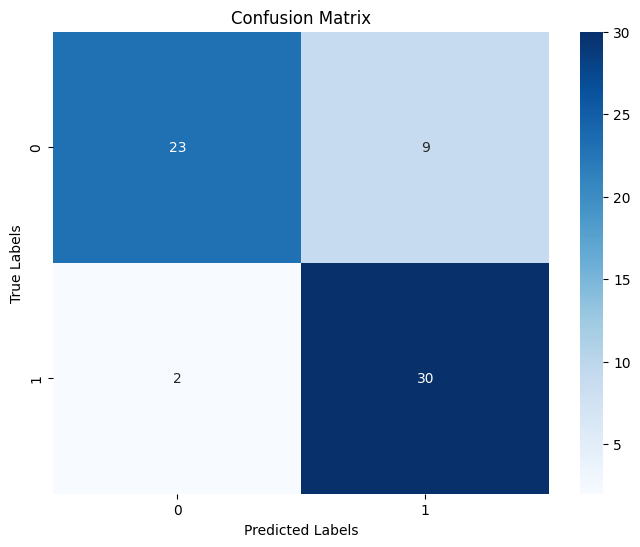

Confusion matrix
23 9
2 30
Accuracy: 0.828125
Precision: 0.7692307692307693
Recall: 0.9375
F1: 0.8450704225352113
Лучшие параметры: {'C': 0.9911526558591411}
Лучший F1: 0.7830925501482499
----------------------------------------------------------------------------------------------------


In [129]:
for kernel in kernels:
    print(kernel)

    model, params = params_for_svc(kernel, 'grid_search')
    if kernel != 'exponential':
        grid_search = GridSearchCV(model, params, cv=kf, scoring='f1_macro')
        grid_search.fit(X_smt_train, y_smt_train)

        best_model = grid_search.best_estimator_
        y_smt_pred_test = best_model.predict(X_smt_test)
        y_smt_pred_train = best_model.predict(X_smt_train)
    else:
        kernel_matrix = exponential_kernel(X_smt_train, X_smt_train, sigma=0.5)

        grid_search = GridSearchCV(model, params, cv=kf, scoring='f1_macro')
        grid_search.fit(kernel_matrix, y_smt_train)

        K_test = exponential_kernel(X_smt_test, X_smt_train, sigma=0.5)

        best_model = grid_search.best_estimator_
        y_smt_pred_test = best_model.predict(K_test)
        y_smt_pred_train = best_model.predict(kernel_matrix)

    print_metrics(y_smt_test, y_smt_pred_test, y_smt_train, y_smt_pred_train)

    print("Лучшие параметры:", grid_search.best_params_)
    print("Лучший F1:", grid_search.best_score_)
    print('--' * 50)

    model, params = params_for_svc(kernel, 'random_search')
    if kernel != 'exponential':
        random_search = RandomizedSearchCV(model, params, n_iter=20, cv=kf, scoring='f1_macro')
        random_search.fit(X_smt_train, y_smt_train)

        best_model = random_search.best_estimator_
        y_smt_pred_test = best_model.predict(X_smt_test)
        y_smt_pred_train = best_model.predict(X_smt_train)
    else:
        kernel_matrix = exponential_kernel(X_smt_train, X_smt_train, sigma=0.5)

        random_search = RandomizedSearchCV(model, params, n_iter=20, cv=kf, scoring='f1_macro')
        random_search.fit(kernel_matrix, y_smt_train)

        K_test = exponential_kernel(X_smt_test, X_smt_train, sigma=0.5)

        best_model = random_search.best_estimator_
        y_smt_pred_test = best_model.predict(K_test)
        y_smt_pred_train = best_model.predict(kernel_matrix)

    print_metrics(y_smt_test, y_smt_pred_test, y_smt_train, y_smt_pred_train)

    print("Лучшие параметры:", random_search.best_params_)
    print("Лучший F1:", random_search.best_score_)

    print('-' * 100)

### Ручная реализация KNN

[[26  6]
 [ 4 28]]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        32
           1       0.82      0.88      0.85        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



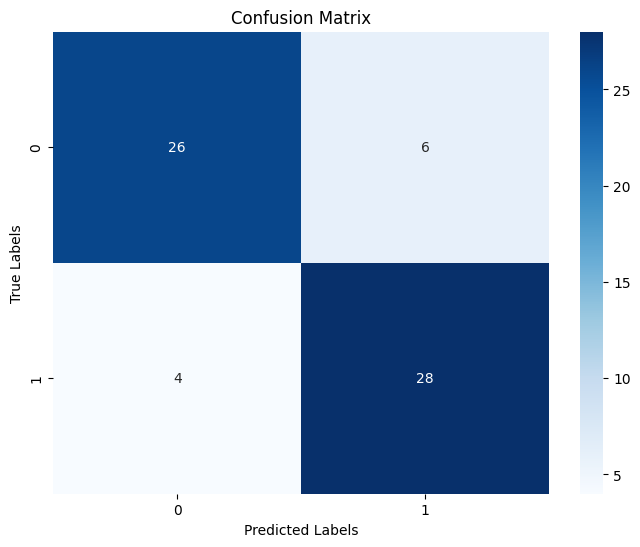

Confusion matrix
26 6
4 28
Accuracy: 0.84375
Precision: 0.8235294117647058
Recall: 0.875
F1: 0.8484848484848485


In [130]:
y_smt_pred = knn_1(X_smt_train, y_smt_train, X_smt_test, 3)

cm = confusion_matrix(y_smt_test, y_smt_pred)

print_metrics(np.array(y_smt_test), np.array(y_smt_pred))

In [131]:
knn = KNNClassifier(k=3, distance_metric='manhattan')
knn.fit(X_smt_train, y_smt_train)

y_pred = knn.predict(X_smt_test)
print("Accuracy:", knn.score(X_smt_test, y_smt_test))

Accuracy: 0.84375


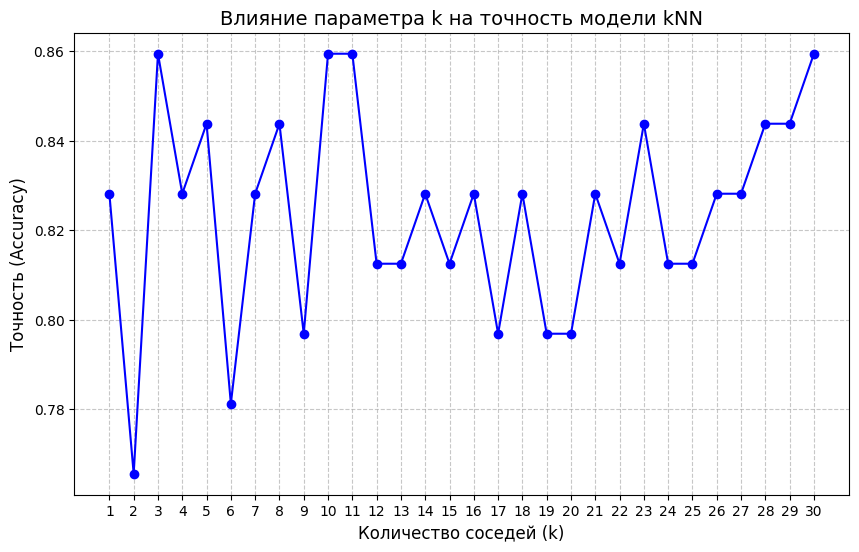

In [132]:
k_values = range(1, 31)
accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_smt_train, y_smt_train)
    y_pred = model.predict(X_smt_test)
    acc = accuracy_score(y_smt_test, y_pred)
    accuracies.append(acc)
    
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('Влияние параметра k на точность модели kNN', fontsize=14)
plt.xlabel('Количество соседей (k)', fontsize=12)
plt.ylabel('Точность (Accuracy)', fontsize=12)
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Вывод

Лучшая модель - SVM c полниномиальным ядром

Confusion matrix

31 1

6 26

Accuracy: 0.890625

Precision: 0.9629629629629629

Recall: 0.8125

F1: 0.8813559322033898

Лучшие параметры: {'C': 1, 'coef0': 0.5, 'degree': 3, 'gamma': 0.01}

Лучший F1: 0.8133191125902913